<a href="https://colab.research.google.com/github/hallpaz/3dsystems23/blob/main/assignments/lab2_learningsignals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

# Lab Class #2 - Learning Signals

In this practice, we are going to verify many of the concepts studied in the class "Learning Signals". If you need to recall the theory, check the video below.

In [1]:
#@title
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/OcxvX4bMnzk', width='560', height='315')

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import imageio

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
from collections import OrderedDict
import numpy as np
import skimage
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.fft import fft, fftfreq
from typing import Sequence, Tuple, Union

import time

import seaborn as sns

In [3]:
torch.manual_seed(777)
sns.set_theme()

# 1 Sampling and Reconstruction

We are going to start working with 1D signals in the interval $[-1, 1]$. Shannon theorem states some conditions for reconstruction of bandlimited signals after uniform sampling. Let's verify it in practice.

In [4]:
def get_mgrid(sidelen, dim=2, start=-1, end=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(start, end, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class Signal1D(Dataset):
    def __init__(self, coords, values):
        super().__init__()
        self.values = values.view(-1, 1)
        self.coords = coords

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.values

def sinusoidal(nsamples, freqs, biases=None):
    coords = get_mgrid(nsamples, 1).view(-1)
    values = torch.zeros(nsamples)
    if biases is None:
      biases = torch.zeros(len(freqs))
    for freq, bias in zip(freqs, biases):
      values = values + torch.sin(freq * coords + bias)
    return Signal1D(coords, values)

def plot_signals(signals:Union[Signal1D, Sequence[Signal1D]]):
    COLORS = ['blue', 'orange', 'green', 'purple', 'pink']
    lines = ['-', '--', '-.', ':']
    fig, ax = plt.subplots(figsize=(16, 8))
    if not isinstance(signals, Sequence):
      signals = [signals]
    for i, signal in enumerate(signals):
        ax.plot(signal.coords, 
                signal.values, 
                label=f'S{i}', color=COLORS[i%len(COLORS)])
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

## 1.1 Uniform Sampling

Let's take some samples of continuous functions uniformly over the interval $[-1, 1]$ an plot them. To make it easier to see we are working with bandlimited signals, we are going to start with combinations of sinusoidal functions, so we know the exact the frequency content of the signal.

In [5]:
def plot_samples1D(func, nsamples):
    x = get_mgrid(nsamples, 1)
    samples = func(x)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(x, samples, 'o', label=f'Uniform samples')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

def multi_plot(dots, curves=[], labels=[]):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(*dots, 'o', label=f'Uniform samples')
    for i, (x, y) in enumerate(curves):
        ax.plot(x, y, label=labels[i])

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

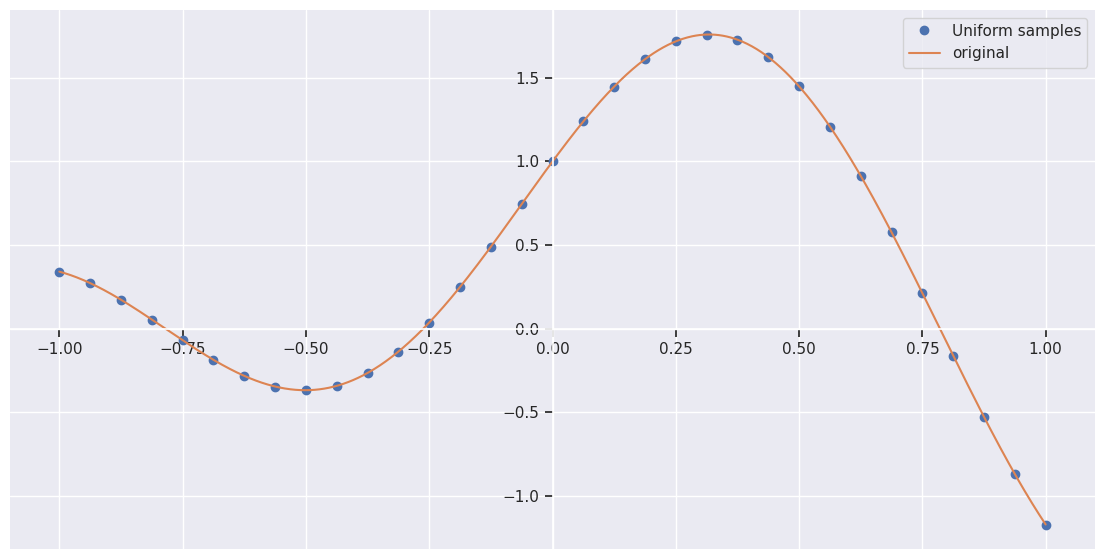

In [6]:
gridres = 1025
nsamples = 33
signal = lambda x: (np.cos(2 * x) + np.sin(4 * x))
full_grid = get_mgrid(gridres, 1)
samples_grid = get_mgrid(nsamples, 1)

multi_plot((samples_grid, signal(samples_grid)), 
           [(full_grid, signal(full_grid))], 
           ['original'])

## 1.2 Reconstruction

* Implement a function to reconstruct a signal sampled uniformly using the Shanon basis, that is the function $sinc(x) = \frac{sin(x)}{x}$. Plot the original signal and the reconstructed signal (sample more points) in the same graph. Did it work? Why?

* Reduce the sampling rate until it's below the Nyquist limit. What happens when you try to reconstruct the signal? Alternatively, you may add higher frequencies to the signal.

* Try again with a signal composed of more frequencies.

In [7]:
# Suggested template
def shannon_reconstruction(x, y):
    # compute what you need
    def rec(t):
        pass
    # return a function that given a coordinate t, 
    # computes the reconstructed value
    return rec

In [8]:
# write your answer here

## 1.3 Fourier Transform

The code below allows you to plot the Fast Fourier Transform of a signal, and check its representation in the frequency domain.

In [9]:
def plot_fft1D(signals):
    COLORS = ['blue', 'orange', 'green', 'purple', 'pink']
    lines = ['-', '--', '-.', ':']
    if not isinstance(signals, Sequence):
      signals = [signals]
    fig, ax = plt.subplots(figsize=(16, 8))
    for i, signal in enumerate(signals):
        W = signal.values.view(-1).cpu().detach().numpy()
        N = len(W)
        yf = fft(W)
        xf = fftfreq(N, 2/N)[:N//2]
        ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]), 
                label=f'S{i}', color=COLORS[i%len(COLORS)])
    plt.legend()

*   Based on the experiments you did on the previous section, use the FFT algorithm to compare the frequencies present in the original signal and its reconstruction. Check it when you have a sampling rate above the Nyquist limit, and also when it's below this limit. Do you see anything interesting?

In [10]:
# write your answer here

# 2 Aliasing

We saw that Aliasing is an effect that causes higher frequencies to be interpreted as lower frequencies under certain conditions. We are going to check how aliasing artifacts look like when we are working with 1D and 2D signals.

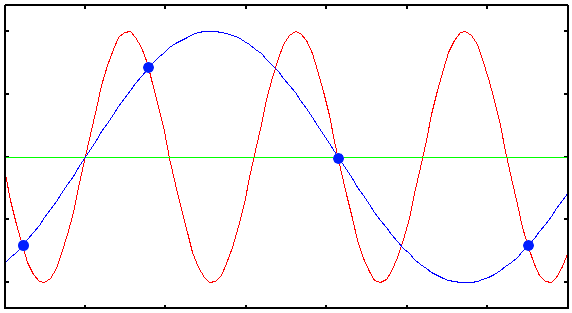

## 2.1 Spoting aliasing artifacts

Perlin Noise is a kind of stochastic signal with large applications in procedural modeling in computer graphics. We are going to use it to generate more sophisticated signals for the next exercise.

In [11]:
def blend(x):
  return 6*x**5 - 15*x**4 + 10*x**3

def noise(scale, samples):
    # create a list of 2d vectors
    angles = torch.rand(scale) * 2*torch.pi
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)

    x = torch.linspace(0, scale-1, samples)
    noise_values = []
    for value in x[:-1]:
        i = torch.floor(value).long()
        lower, upper = gradients[i], gradients[i+1]

        dot1 = torch.dot(lower, torch.tensor([value - i, 0]))
        dot2 = torch.dot(upper, torch.tensor([value - i - 1, 0]))
        # TODO: review interpolation
        k1 = blend(value-i)
        k2 = blend(i+1 - value)
        interpolated = k1*dot2 + k2*dot1 
        noise_values.append(interpolated.item())
    
    noise_values.append(0.0)
    return torch.tensor(noise_values)

def perlin_noise(nsamples, scale=10, octaves=1, p=1):
    pnoise = 0
    for i in range(octaves):
        partial = noise(2**i * scale, nsamples)/(p**i)
        pnoise = partial + pnoise
    return Signal1D(get_mgrid(nsamples, 1), pnoise)

* Generate some Perlin Noise signals exploring different setting of its parameters. When you have an idea of how it works, choose one that presents fine details. Plot the signal and its FFT. Analyze what you see.

In [12]:
# write your answer here

* Create a new Perlin Noise signal from your previously generated signal by naively subsampling it: just keep 1 sample for every *sumbsampling_factor* samples and ignore the others.
* Use the sinc basis to reconstruct the noise signal and compare the original signal to the reconstructed signal. Can you spot any alising artifacts? If so, describe them.
* Check the FFT plot for both the original noise signal and the reconstructed noise signal.

In [13]:
# write your answer here

## 2.2 Aliasing Artifacts in Images

Download the image of a striped t-shirt using the code below, then load and display the image.

In [14]:
# download image
!wget https://raw.githubusercontent.com/hallpaz/3dsystems23/main/data/camisa.jpg

--2023-04-04 16:00:41--  https://raw.githubusercontent.com/hallpaz/3dsystems23/main/data/camisa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255515 (250K) [image/jpeg]
Saving to: ‘camisa.jpg’

camisa.jpg          100%[===================>] 249.53K  --.-KB/s    in 0.03s   

2023-04-04 16:00:41 (7.66 MB/s) - ‘camisa.jpg’ saved [255515/255515]



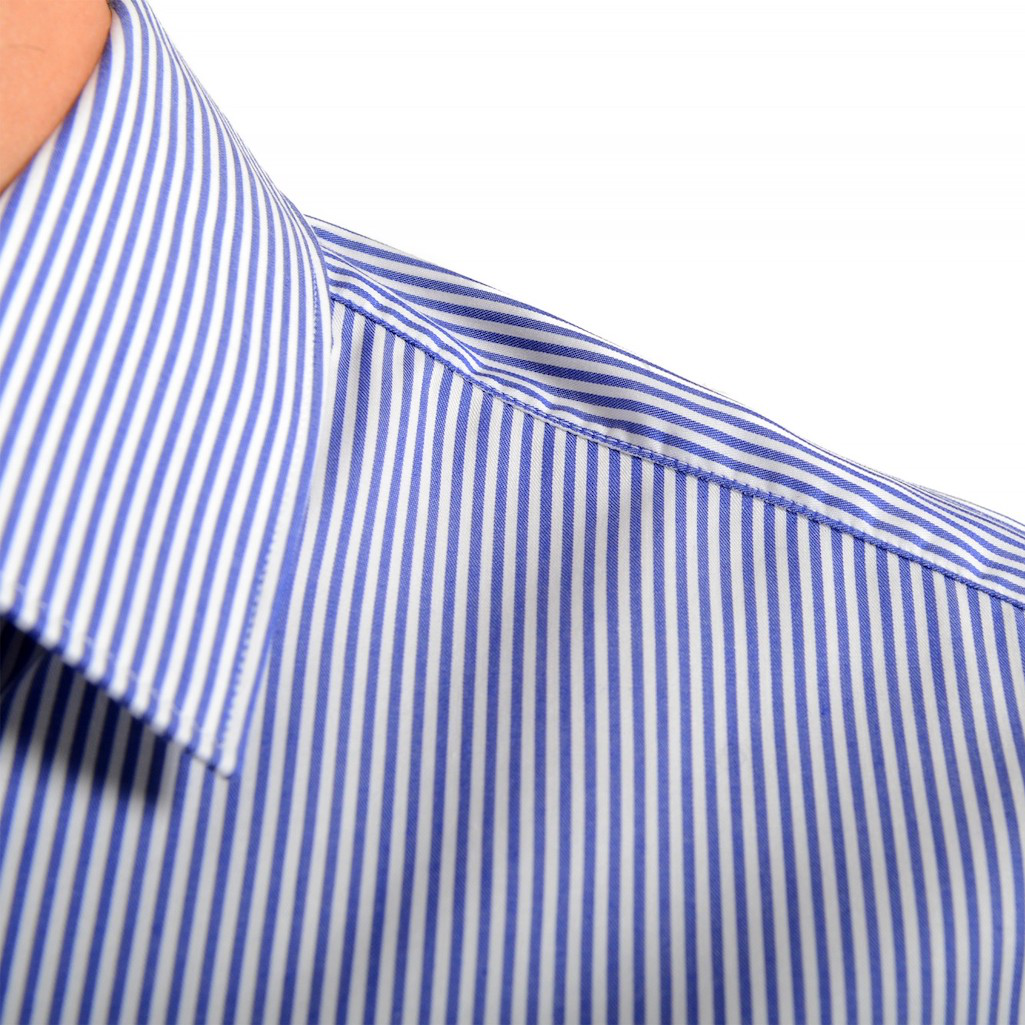

In [15]:
tshirt = Image.open('/content/camisa.jpg')
tshirt

* Convert the image to a tensor or numpy array representation and naively subsample it by a factor of 8. After checking the result, can you see any alising artifacts? Explain.

* Try a higher subsampling factor. Does it display more artifacts?

If you prefer, you can resize the image to a bigger size using the following snippet:

```python
# img is a numpy array that contains the pixels values
# dim is the new size; e.g. 513
Image.fromarray(img).resize((dim, dim), Image.BICUBIC)
```

In [16]:
# write your answer here

# 3 Fitting an 2D signal (image) using a neural network

In the previous assignment, you learned how to train a neural network to fit a 1D function using the basic components in the PyTorch framework. Now, we are going to solve a similar problem, but in 2D.



In [17]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageSignal(Dataset):
    def __init__(self, sidelength, path=None):
        super().__init__()
        if path is None:
          img = get_cameraman_tensor(sidelength)
        else:
          img = Image.open(path).convert('L').resize((sidelength, sidelength))
          img = to_tensor(img)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.dim = sidelength

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

class ReLuNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, coords):
        output = self.layers(coords)
        return output

def plot_tensor_img(output, dim, return_img=False):
    img = output.cpu().view(dim, dim).detach().numpy()
    if return_img:
        return img
    plt.grid(False)
    plt.imshow(img, cmap='gray')

def train(model, dataloader, epochs, device, steps_til_summary=100, gif_path=""):
    model.to(device)
    model.train()
    optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)
    
    dim = int(np.sqrt(len(ground_truth.view(-1))))
    if gif_path:
        writer = imageio.get_writer(gif_path, mode='I', duration=0.3)

    for step in range(epochs):
        model_output = model(model_input)    
        loss = ((model_output - ground_truth)**2).mean()

        if not (step % steps_til_summary):
            print("Step %d, Total loss %0.6f" % (step, loss))
            plot_tensor_img(model_output, dim)

        if gif_path and (step % 5 == 0):
            img = np.clip(model_output.cpu().view(dim, dim).detach().numpy(), 0, 1) 
            writer.append_data(np.uint8(img * 255))

        optim.zero_grad()
        loss.backward()
        optim.step()
    # last inference
    model.eval()
    model_output = model(model_input)
    img = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
    writer.append_data(np.uint8(img * 255))
    writer.close()

## 3.1 Training a regular MLP using ReLu as activation function

* Train a model using the ReLuNetwork provided in code cell above. Try to fit at least 2 images. What do you observe in the result?

* **[Optional]** Can you do better? Experiment different activation functions and/or a different set of hyperparameters and try to improve the result. Feel free to change the network architecture.



In [18]:
# write your answer here

## 3.2 Fourier Transform of Images

In [19]:
def plot_fft2D(pixels:torch.Tensor, dim):
    fourier_tensor = torch.fft.fftshift(
                    torch.fft.fft2(pixels.view(dim, dim).squeeze(-1)))
    magnitude = 20 * np.log(abs(fourier_tensor.numpy()) + 1e-10)
    mmin = np.min(magnitude)
    magnitude = (magnitude - mmin) / (np.max(magnitude) - mmin)
    img = np.uint8(magnitude * 255)
    plt.grid(False)
    plt.imshow(img, cmap='gray')

The code above computes the Fast Fourier Transform of a 2D image and displays the magnitude of the FFT as another image. The lower frequencies will appear near the center of the image while the higher frequencies will appear near the border of the image. The magnitude is normalized for better visualization.

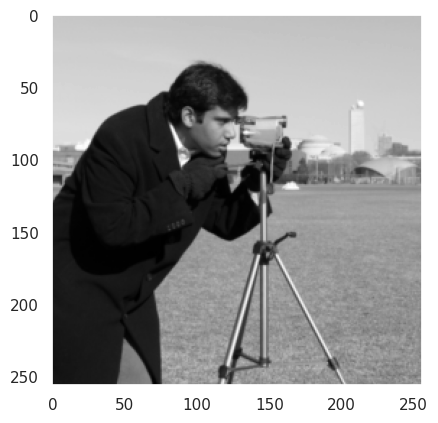

In [20]:
example = ImageSignal(256)
plot_tensor_img(example.pixels, example.dim)

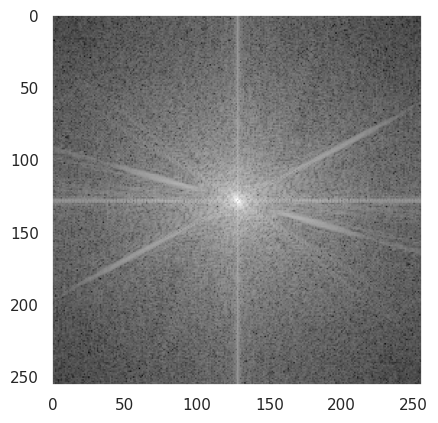

In [21]:
plot_fft2D(example.pixels, example.dim)

* Visualize the FFT of the result image of the trained model. How does it compare to the ground truth?

In [22]:
# write your answer here

## 3.3 Training a Sinusoidal Neural Network to fit an image

In [23]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output

The code above defines a simplified version of a SIREN* (sinusoidal representation network. This kind of network uses sines as the activation function. 

Notice that it's not as trivial as changing $relu()$ for $sin()$, as it requires a special initialization to guarantee stability and convergence during training. You can find the paper and the original [code in this link](https://www.vincentsitzmann.com/siren/), and check the details.

* Train a Siren network to fit the same images you were working with. Is the result better? Explain.

* Use the FFT to analyze the frequencies learned by the network. Why do you think the FFT plots of the Relu and Siren networks are so different?

In [24]:
# write your answer here